In [1]:
# Standard library imports
import os
import sys
import random

# Important directories
code_dir = os.path.dirname(os.getcwd())
deep_cal_dir = os.path.dirname(os.path.dirname(os.getcwd()))
# Allows to import my own module
sys.path.insert(0, code_dir)

from miscellaneous.helpers import StyblinskiTang, StyblinskiTangNN, PlotStyblinskiTang, plot_results
from miscellaneous.dataloader import SobolevDataset
from miscellaneous.models import SobolevRegressor
from miscellaneous.train_sobolev import train_sobolev

from ann.helpers import open_data

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

random.seed(0)

In [2]:
rho_min = -95
rho_max = -0.05
kappa_min = 10
kappa_max = 150.0
nu_min = 10
nu_max = 50
gamma_min = 10
gamma_max = 50
v_min = 5
v_max = 50
K_min  = 7000
K_max = 13000
#min_ = [rho_min,kappa_min,nu_min,gamma_min,v_min,K_min]
#max_ = [rho_max,kappa_max,nu_max,gamma_max,v_max,K_max]
min_ = [0.7,4/365,0.0001]
max_ = [1.3,730/365,0.1]
sample_heston = np.random.uniform(low=min_, high=max_, size=(2000,3))/100

In [3]:
#value_ = {'rho':sample_heston[:,0],'kappa':sample_heston[:,1],'theta':sample_heston[:,2],  'sigma':sample_heston[:,3], 'V0':sample_heston[:,4]}
value_ = {'K':sample_heston[:,0],'T':sample_heston[:,1],'r':sample_heston[:,2]}
database = pd.DataFrame(value_)
print(database.tail())
database.to_csv('data/tmp_heston.csv',index=False)

             K         T         r
1995  0.009518  0.015824  0.000336
1996  0.007154  0.000435  0.000763
1997  0.010252  0.015597  0.000676
1998  0.009299  0.006550  0.000557
1999  0.011251  0.014984  0.000940


In [4]:
data = open_data('data/tmp_heston.csv')
data = data.to_numpy()
train_data = data[:1000]
test_data = data[1001:]

In [5]:
train_dataset =SobolevDataset(train_data)
test_dataset =SobolevDataset(test_data)

In [17]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=20,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1000,
                          shuffle=True,
                          num_workers=0)

In [18]:
import torch
from torch import nn, optim
import torch.nn.functional as F

_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SobolevRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 256)

        self.fc2 = nn.Linear(256, 256)

        self.fc3 = nn.Linear(256, 256)

        self.fc4 = nn.Linear(256,1)
    
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        
        return x
    
model = SobolevRegressor()

In [19]:
import os
import sys

code_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, code_dir)

from complex import *
from quadrature import GaussLegendreQuadrature1D
import torch
import torch.nn as nn

class TorchHestonFourier(nn.Module):

    def __init__(self,S0,kappa,theta,rho,sigma,V0, alpha, precision):
        super().__init__()
        self. S0 = S0
        #self.nu = nu
        self.kappa = kappa
        self.theta = theta
        self.rho = rho
        self.sigma = sigma
        self.V0 = V0
        #self.K = K
        #self.r = r
        #self.T = T
        self.precision = precision
        self.alpha = alpha

    def forward(self,K,T,r):
        """
        
        Args :
        ------
            kappa: speed of mean reversion
            theta: long term vol
            rho: spot-vol correlation
            sigma: vol of vol
            V0: forward variance curve
            
        Return:
        -------
            Heston Price
        """
        #nu = torch.ones(K.size()).T * self.nu
        kappa = torch.ones(K.size()).T * self.kappa
        theta = torch.ones(K.size()).T * self.theta
        rho = torch.ones(K.size()).T * self.rho
        sigma = torch.ones(K.size()).T * self.sigma
        V0 = torch.ones(K.size()).T * self.V0
        #r = torch.ones(K.size()).T * self.r
        #T = torch.ones(kappa.size()).T * self.T
        S0 = torch.ones(K.size()).T * self.S0
        f = lambda nu : TorchPsi(nu,self.alpha,K,kappa,S0,r,T,theta,rho,sigma,V0)
        gg = GaussLegendreQuadrature1D()
        res = gg.forward(f,0,self.precision)
        return res

def TorchPhi(u,kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_):
        size = kappa_.size()
        gamma_ = (Complex(u ** 2,u)*((torch.pow(sigma_,2)))+(Complex(kappa_,u*-1*rho_*sigma_)**2))**(1/2)
        a = Complex(torch.zeros(size,dtype=torch.float64),u*torch.log(S0_)) + Complex(torch.zeros(size,dtype=torch.float64),u*r_*tau_) + (Complex(kappa_,torch.zeros(kappa_.size(),dtype=torch.float64)) - Complex(torch.zeros(size,dtype=torch.float64),u*rho_*sigma_))*(kappa_*theta_*tau_)*(1/(sigma_**2))
        b = Complex((u**2)*V0_,u*V0_).div(gamma_ * TorchCosh((gamma_*tau_)*(1/2)).div(TorchSinh((gamma_*tau_)*(1/2))) + (Complex(kappa_,torch.zeros(kappa_.size()))- Complex(torch.zeros(size),rho_*sigma_*u))  )
        c = TorchCosh((gamma_*tau_)*(1/2)) + (Complex(kappa_,torch.zeros(kappa_.size()))- Complex(torch.zeros(size),rho_*sigma_*u)).div(gamma_)*TorchSinh((gamma_*tau_)*(1/2)) 
        d = 2*kappa_*theta_/(sigma_**2)
        return Torchexp(a) * Torchexp(-b)*(c**d)**(-1)


def TorchPsi(nu,alpha,K,kappa,S0,r,tau,theta,rho,sigma,V0):
    k = torch.log(K)
    F = TorchPhi(Complex(nu,torch.ones(nu.size())*-(alpha+1)),kappa,S0,r,tau,theta,rho,sigma,V0) * Torchexp(Complex(torch.zeros(nu.size()),-nu*k))
    d = Complex(alpha,nu) * Complex(alpha+1,nu)
    return ((torch.exp(-r*tau-alpha*k)/math.pi)*(F.div(d))).re


In [20]:
#!/usr/bin/env python3

import math

import numpy as np
import torch
import torch.nn as nn 


from gpytorch.utils.broadcasting import _pad_with_singletons


class GaussHermiteQuadrature1D(nn.Module):
    """
    Implements Gauss-Hermite quadrature for integrating a function with respect to several 1D Gaussian distributions
    in batch mode. Within GPyTorch, this is useful primarily for computing expected log likelihoods for variational
    inference.

    This is implemented as a Module because Gauss-Hermite quadrature has a set of locations and weights that it
    should initialize one time, but that should obey parent calls to .cuda(), .double() etc.
    """

    def __init__(self, num_locs=156):
        super().__init__()
        self.num_locs = num_locs

        locations, weights = self._locs_and_weights(num_locs)

        self.locations = locations
        self.weights = weights

    def _apply(self, fn):
        self.locations = fn(self.locations)
        self.weights = fn(self.weights)
        return super(GaussHermiteQuadrature1D, self)._apply(fn)

    def _locs_and_weights(self, num_locs):
        """
        Get locations and weights for Gauss-Hermite quadrature. Note that this is **not** intended to be used
        externally, because it directly creates tensors with no knowledge of a device or dtype to cast to.

        Instead, create a GaussHermiteQuadrature1D object and get the locations and weights from buffers.
        """
        locations, weights = np.polynomial.legendre.leggauss(1000)
        locations = torch.Tensor(locations)
        weights = torch.Tensor(weights)
        return locations, weights

    def forward(self, func, a=0,b=1):
        """
        Runs Gauss-Hermite quadrature on the callable func, integrating against the Gaussian distributions specified
        by gaussian_dists.

        Args:
            - func (callable): Function to integrate
            - gaussian_dists (Distribution): Either a MultivariateNormal whose covariance is assumed to be diagonal
                or a :obj:`torch.distributions.Normal`.
        Returns:
            - Result of integrating func against each univariate Gaussian in gaussian_dists.
        """
        lower_bound = torch.Tensor([a])
        higher_bound =  torch.Tensor([b])

        locations = _pad_with_singletons(self.locations, num_singletons_before=0, num_singletons_after=lower_bound.dim())
        t = 0.5*(locations + 1)*(higher_bound - lower_bound) + lower_bound

        x1 = t
        fx = func(x1)
        weights = _pad_with_singletons(self.weights, num_singletons_before=0, num_singletons_after=fx.dim() - 1)
        #res = torch.dot(fx,self.weights) #
        """shifted_locs = 0.5 * (locations + 1)*(variances-means) + means
        log_probs = func(shifted_locs)
        weights = _pad_with_singletons(self.weights, num_singletons_before=0, num_singletons_after=log_probs.dim() - 1)
        """
        res = (fx * weights)
        res = res.sum(tuple(range(self.locations.dim())))

        return res * 0.5 * (higher_bound - lower_bound)
    


In [10]:
def TorchPhi(u,kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_):
    size = kappa_.size()
    gamma_ = (Complex(u ** 2,u)*((torch.pow(sigma_,2)))+(Complex(kappa_,u*-1*rho_*sigma_)**2))**(1/2)
    a = Complex(torch.zeros(size,dtype=torch.float64),u*torch.log(S0_)) + Complex(torch.zeros(size,dtype=torch.float64),u*r_*tau_) + (Complex(kappa_,torch.zeros(kappa_.size(),dtype=torch.float64)) - Complex(torch.zeros(size,dtype=torch.float64),u*rho_*sigma_))*(kappa_*theta_*tau_)*(1/(sigma_**2))
    b = Complex((u**2)*V0_,u*V0_).div(gamma_ * TorchCosh((gamma_*tau_)*(1/2)).div(TorchSinh((gamma_*tau_)*(1/2))) + (Complex(kappa_,torch.zeros(kappa_.size()))- Complex(torch.zeros(size),rho_*sigma_*u))  )
    c = TorchCosh((gamma_*tau_)*(1/2)) + (Complex(kappa_,torch.zeros(kappa_.size()))- Complex(torch.zeros(size),rho_*sigma_*u)).div(gamma_)*TorchSinh((gamma_*tau_)*(1/2)) 
    d = 2*kappa_*theta_/(sigma_**2)
    return Torchexp(a) * Torchexp(-b)*(c**d)**(-1)

def TorchPsi(nu_,alpha_,K_,kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_):
    k_ = torch.log(K_)
    F = TorchPhi(Complex(nu_,torch.ones(nu_.size())*-(alpha_+1)),kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_) * Torchexp(Complex(torch.zeros(nu_.size()),-nu_*k_))
    d = Complex(alpha_,nu_) * Complex(alpha_+1,nu_)
    return ((torch.exp(-r_*tau_-alpha_*k_)/math.pi)*(F.div(d))).re


def TorchHestonFourier(alpha_,K_,kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_,L_):
    f = lambda nu_: TorchPsi(nu_,alpha_,K_,kappa_,S0_,r_,tau_,theta_,rho_,sigma_,V0_)
    gg = GaussHermiteQuadrature1D()
    res = gg.forward(f,0,L_)
    return res

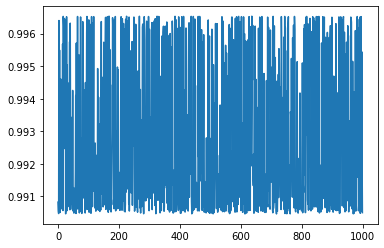

In [21]:
from torch.autograd import Variable
heston = TorchHestonFourier(1.,0.5,0.25*0.25,-0.75,1,0.01,0.1,10)
train_data = torch.Tensor(train_data)
train_data = Variable(train_data[:,:5], requires_grad = True)
res = heston(train_data[:,0],train_data[:,1],train_data[:,2])
res = res.unsqueeze(1)
#res = TorchHestonFourier(0.1,torch.ones(train_data[:,1].size())*0.9,train_data[:,1],torch.ones(train_data[:,1].size())*1.,torch.ones(train_data[:,1].size())*0.01,torch.ones(train_data[:,1].size())*0.5,train_data[:,2],train_data[:,0],train_data[:,3],train_data[:,4],1)
#res = res.unsqueeze(1)
"""for i in train_loader:
    i = Variable(i,requires_grad=True)
    store.append(heston(i[:,1],i[:,2],i[:,0],i[:,3],i[:,4]))
"""

from jacobian import Jacobian
jac = Jacobian()
jac(train_data,res)
import matplotlib.pyplot as plt
plt.plot(res.detach().numpy())

In [22]:
import os
import sys

code_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, code_dir)

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import pandas as pd

from torch import nn, optim
import torch
from torch.autograd import Variable, grad
from torch.utils.tensorboard import SummaryWriter

import numpy as np

from ann.model import init_weights
from miscellaneous.jacobian import Jacobian
from miscellaneous.helpers import StyblinskiTangNN

_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(code_dir + '/ann/runs/lifted_heston_experiment')

f1 = TorchHestonFourier(1.,0.5,0.25*0.25,-0.75,1,0.01,0.1,10)


def train_sobolev(model,
                  train_loader,
                  test_loader,
                  lambd,
                  nb_epochs,
                  seed, 
                  save_model_dir,
                  log_df= 'log_df.csv'):
    """
    Arguments:

        train_loader:   Dataloader. 
            train_loader.features: array-like, shape=[# samples, # features].
                Features of the data set.
            train_loader.labels: array-like, shape=[# samples, # labels].
                Labels of the data set.
        test_loader:   Dataloader.
            test_loader.features: array-like, shape=[# samples, # features].
                Features of the data set.
            test_loader.labels: array-like, shape=[# samples, # labels].
                Labels of the data set.
        lambd: double.
            Proportion for the sobolev mean squared error.
        nb_epochs: integer.
            Number of epochs to train the network.
        seed: integer.
            Random seed for PRNG, allowing reproducibility of results.
        project_dir: string.
            Project directory to write to.
        log_df: pandas dataframe, shape=[, nb_layers + 8], default = None
            Pandas df that serves as a log file. If none, df is created.
    Returns:
        log_df: pandas dataframe.
            Pandas df log file with training and validation metrics across eps.
        best_error: float
            Best error on test set among epochs.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),lr=0.0005)

    train_loss_min = np.Inf
    steps = 0
    model.apply(init_weights)
    model.to(_device)
    jacobian = Jacobian()
    train_losses,train_L1losses,train_L2losses, test_losses,test_L1losses, learningRate = [], [], [], [],[],[]

    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    
    epochs_iter = tqdm_notebook(range(nb_epochs), desc="Epoch")
    for e in epochs_iter:
        running_loss = 0
        L1Loss = 0
        L2Loss = 0
        for features in train_loader:
            
            features = features.type(torch.FloatTensor)
            features = features.to(_device)

            features = Variable(features,requires_grad = True)
            #print(features)
            labels = f1(features[:,0],features[:,1],features[:,2]) #,features[:,3],features[:,4])
            labels = labels.unsqueeze(1)


            MSE = model(features)
            #print(labels)
            
            #MSE.requires_grad = True

            #labels = Variable(labels,requires_grad=True)

            J_teacher = jacobian(features, labels)
            J_student = jacobian(features, MSE)
            #print(J_teacher)
            loss = criterion(MSE, labels) 

            loss_sobolev = criterion(J_teacher.flatten(), J_student.flatten())

            loss_total =  loss + lambd * loss_sobolev

            optimizer.zero_grad() # dé-commenter si on utilise pas Adatune
            loss_total.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 2000)

            optimizer.step()
 
            L1Loss += loss.item()
            L2Loss += loss_sobolev.item()
            running_loss += loss_total.item()

        else:
            test_L1loss = 0
            test_L2loss = 0
            test_loss = 0
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                model.eval()
                for features1 in test_loader:
                    
                    
                    features1 = features1.type(torch.FloatTensor)

                    #features1= features1.to(_device)  #,dlabels1.to(_device)
                    labels1 = f1(features1[:,0],features1[:,1],features1[:,2])  #,features1[:,3],features1[:,4])
                    MSE = model(features1)
                    labels1 = labels1.unsqueeze(1)
                    test_L1loss += criterion(MSE, labels1)
                    
                    test_loss += test_L1loss 

                    
                    
                    
            model.train()        
            train_losses.append(running_loss/len(train_loader))
            train_L1losses.append(L1Loss/len(train_loader))
            train_L2losses.append(L2Loss/len(train_loader))

            test_loss = test_loss/len(test_loader)
            test_losses.append(test_loss)
            test_L1losses.append(test_L1loss/len(test_loader))


            learningRate.append(optimizer.param_groups[0]['lr'])
            #scheduler.step(test_loss)

            """print(
                  "Training Loss: {:.7f}.. ".format(L1Loss/len(train_loader)),
                  "Training Sobolev Loss: {:.7f}..".format(L2Loss/len(train_loader)),
                  "Training Full Loss: {:.7f}..".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(np.sqrt(test_loss)))"""
            # save model if validation loss has decreased
            if running_loss <= train_loss_min:
                #print('Validation loss decreased ({} --> {}).  Saving model ...'.format(train_loss_min,running_loss))
                #torch.save(model.state_dict(),save_model_dir)
                train_loss_min = running_loss
            
    #learning_data = pd.DataFrame(list(zip(train_losses,train_L1losses, train_L2losses, test_losses, test_L1losses, learningRate)),columns=['Train Losses', 'Train L1 Losses', 'Train L2 Losses','Test Losses','Test L1 Losses', 'Learning Rate'])
    #learning_data.to_csv(log_df,index=False)
    
    return train_L1losses, train_L2losses, test_losses

In [23]:
tr1, tr2, tes = train_sobolev(model,train_loader,test_loader,1,100,0, 'results/heston_tmp.pt',log_df= 'log_df.csv')

In [ ]:
from matplotlib import pyplot as plt
plt.plot(tr1,label='L1')
#plt.plot(tr2,label='L2')
plt.plot(tes,label='test')
plt.yscale('log')
plt.legend()


In [ ]:
T = torch.ones((20)) * .1
K = np.linspace(30,300,20) # 0.3,0.4,0.6,0.8,0.9,0.95,0.975,1,1.025,1.05,1.1,1.2,1.3,1.5,1.75,2,2.5,3
"""TT,KK = np.meshgrid(T,K)
TT = torch.Tensor(TT).flatten()
KK = torch.Tensor(KK).flatten()"""
heston = TorchHestonFourier(100,K,0.01,T,0.1,1000)

In [ ]:
# rho     kappa     theta     sigma        V0
kappa = torch.ones((20)) * 1.
theta = torch.ones((20)) * 0.1
rho = torch.ones((20)) * -0.7
sigma = torch.ones((20)) * 0.1
V0 = torch.ones((20)) * 0.04

In [ ]:
res = heston.forward(kappa,theta,rho,sigma,V0)

In [ ]:
res

In [ ]:
reg = SobolevRegressor()
_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reg.load_state_dict(torch.load('results/heston_tmp.pt',map_location=torch.device(_device)))

In [ ]:
from pricing.heston_fourier import price_heston_fourier
hst_classic = []
for i in K:
    hst_classic.append(price_heston_fourier(K_=i,alpha_=0.1,r_=0.01,tau_=.5,kappa_=1,S0_=100,theta_=0.1,rho_=-0.7,sigma_=0.1,V0_=0.04,L_=1000))
    

In [ ]:
hst_classic

In [ ]:
res1 = torch.reshape(res,(20,1))

In [ ]:
from matplotlib import pyplot as plt
plt.matshow(res1)

In [ ]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def set_style():

    sns.set_context("paper")

    sns.set(font='serif')
    
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
set_style()
%matplotlib inline

# Functions for Black-Scholes related computations
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
def price(k,v):
    """
    k.shape = () : log-strike
    v.shape = () : total variance
    """
    σ = np.sqrt(v)
    d1 = -k/σ + 0.5*σ
    d2 = d1 - σ
    p = norm.cdf(d1) - np.exp(k)*norm.cdf(d2)
    return p
def obj_func(σ,k,t,p):
    """
    σ.shape = () : bs volatility
    k.shape = () : log-strike
    t.shape = () : years to maturity
    p.shape = () : option price
    """
    e = price(k,σ**2*t) - p
    return e

def vol(k,t,p):
    """
    k.shape = () : log-strike
    t.shape = () : years to maturity
    p.shape = () : option price
    """
    p = np.maximum(p, np.maximum(1. - np.exp(k),0))
    σ = brentq(obj_func,1e-11,1e+9,args=(k,t,p))
    return σ

def surface(k,T,p):
    """
    k.shape = (m,n) : log-strikes
    t.shape = (m,) : years to maturity
    p.shape = (m,n) : option prices
    """
    m,n = k.shape
    σ = [[vol(k[i,j],T[i],p[i,j]) for j in range(n)] for i in range(m)]
    return np.array(σ)

In [ ]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException
K = np.linspace(30,300,20)

vol_imp = []
for i in range(20):
    try :
        vol_imp.append(implied_volatility(np.array(res[i],dtype=np.float64),100,K[i],0.5,0.01,'c'))
        #vol_imp.append(vol(np.log(K[i]),0.5,res[i]))
    except:
        vol_imp.append(np.nan)

vol_imp1 = np.reshape(vol_imp,(20,1))

In [ ]:
vol_imp

In [ ]:
plt.plot(np.log(K/100),(vol_imp1**2)*0.8)


In [ ]:
KK = np.array(KK)
TT = np.array(TT)


In [ ]:
import holoviews as hv
hv.extension('matplotlib')
hv.TriSurface((KK[i],TT[i],vol_imp)).opts(linewidth=0.,azimuth=110, elevation=30, fig_size=200)